In [1]:
import torch
from transformers import pipeline as model
from PIL import Image
import matplotlib.pyplot as plt

c:\Users\TheKi\OneDrive - UVG\Semestre X\Responsible AI\MobileNetV2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the model

In [2]:
pipeline = model(
    task="image-classification",
    model="google/mobilenet_v2_1.4_224",
    dtype=torch.float16,
    device=0
)

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 988.76it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [3]:
pipeline("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg")

[{'label': 'lynx, catamount', 'score': 0.49208787083625793},
 {'label': 'tiger cat', 'score': 0.053095635026693344},
 {'label': 'tiger, Panthera tigris', 'score': 0.022047264501452446},
 {'label': 'wombat', 'score': 0.019532792270183563},
 {'label': 'tabby, tabby cat', 'score': 0.01871127262711525}]

## Choose the images

In [4]:
images_path = "data/"

In [5]:
images = [Image.open(images_path + "img_{}.jpg".format(i)) for i in range(1, 4)]

## Make predictions

In [6]:
predictions = pipeline(images, top_k=5)


Resultados para img_1.jpg:


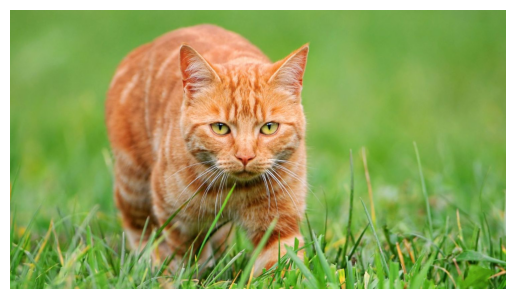

  tiger cat: 0.7237
  tabby, tabby cat: 0.1511
  Egyptian cat: 0.0146
  Persian cat: 0.0025
  ping-pong ball: 0.0014

----------------------------------------------------------------------

Resultados para img_2.jpg:


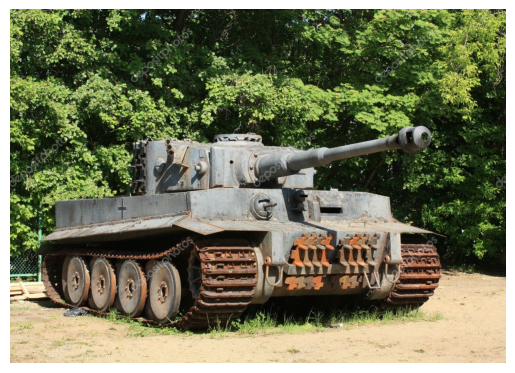

  tank, army tank, armored combat vehicle, armoured combat vehicle: 0.8034
  cannon: 0.0196
  amphibian, amphibious vehicle: 0.0071
  half track: 0.0063
  mortar: 0.0043

----------------------------------------------------------------------

Resultados para img_3.jpg:


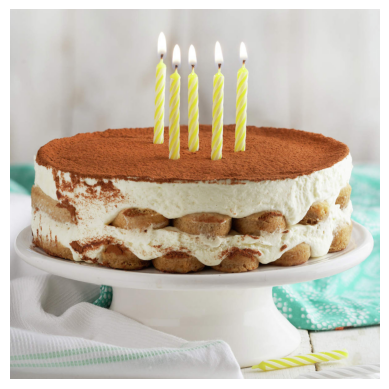

  candle, taper, wax light: 0.2022
  trifle: 0.1091
  potpie: 0.0451
  matchstick: 0.0383
  ice cream, icecream: 0.0383

----------------------------------------------------------------------


In [7]:
for i, preds in enumerate(predictions, 1):
    print(f"\nResultados para img_{i}.jpg:")
    plt.imshow(images[i-1])
    plt.axis('off')
    plt.show()
    for p in preds:
        print(f"  {p['label']}: {p['score']:.4f}")
    print("\n" + "-"*70)